## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv(r'C:\Users\H\Downloads\ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
df.converted.mean()


0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page'))
== False].shape[0]


3893

f. Do any of the rows have missing values?

In [7]:
null_data=df.isnull().values.any()
null_data

False

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# first specification get treatment with new page
df_t = df.query('group == "treatment" and landing_page == "new_page"')

#Second specification get control with old page
df_c = df.query('group == "control" and landing_page == "old_page"')

# To build new dataset merge two but merge will be outer as default inner
df2 = df_t.merge(df_c, how='outer')
df2.head()
df2.shape

(290585, 5)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
 sum(df2['user_id'].duplicated())

1

c. What is the row information for the repeat **user_id**? 

In [12]:
 df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
# Check size before remove
df2.shape[0]
# Drop duplicate
#df.drop_duplicates(subset=['user_id'] ,keep='first',inplace=True)
df2 = df2[~df2.user_id.duplicated(keep='first')]

# Check size after remove
df2.shape[0]

290584

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2_control = df2.query('group == "control"')['converted'].mean()
df2_control 

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2_treatment= df2.query('group == "treatment"')['converted'].mean()
df2_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2.query("landing_page == 'new_page'").count()[0]/df2.shape[0]


0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Your answer goes here.**

According to results the conversion rate for treatment group is 11.8% and the conversion rate for control group is 12.03%. This may indicate that the treatment group does not show  more conversions than the control group. In spite of that there is no evidence that new page shows to more conversions.


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

Null Hypotheses:**$p_{new}$**-**$p_{old}$** <=0

Alternative Hypothesis:**$p_{new}$**- **$p_{old}$** >0


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old= df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new = df2.query("group == 'treatment'")['user_id'].count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old = df2.query("group == 'control'")['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted =  np.random.binomial(1, p_new, n_new)
new_page_converted.mean()

0.12055605257724863

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.binomial(1, p_old, n_old)

old_page_converted.mean()

0.1211434943623773

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
new_page_converted.mean()- old_page_converted.mean()

-0.0005874417851286645

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

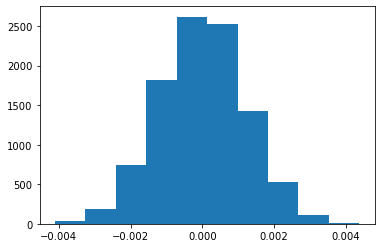

In [25]:
p_diffs = []
p_new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
p_old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = p_new_page_converted - p_old_page_converted
p_diffs = np.array(p_diffs)

plt.hist(p_diffs);

#p_diffs = [] 
#for _ in range(10000):
 #   b_samp = df2.sample(df2.shape[0], replace = True)
 #  p_new_page_converted = b_samp.query('landing_page == "new_page"')['converted'].mean()
 #  p_old_page_converted = b_samp.query('landing_page == "old_page"')['converted'].mean()
 # p_diffs.append(p_new_page_converted - p_old_page_converted)
    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

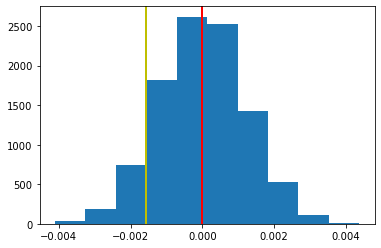

In [26]:
data_diff = df2_treatment - df2_control
data_diff

(p_diffs > data_diff).mean()
(p_diffs < data_diff).mean()

low = data_diff
upper = (np.array(p_diffs).mean())

plt.hist(p_diffs);
plt.axvline(x=upper, color='r', linewidth=2)
plt.axvline(x=low, color='y', linewidth=2)


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
# calculate p-value
(p_diffs > data_diff).mean()

0.9053

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**

p-value  is the probability of observing our statistic assuming that the null hypothesis is correct.
In our case :
Null Hypotheses: 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑  <=0
Alternative Hypothesis: 𝑝𝑛𝑒𝑤 -  𝑝𝑜𝑙𝑑  >
AS  the p-value = 9044 , There is not statistically significent evidence that suggests the new page.
So we fail to reject the null .

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:

import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page'")['converted'].sum()
convert_new = df2.query("landing_page == 'new_page'")['converted'].sum()
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [29]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

p-value  is the probability of observing our statistic assuming that the null hypothesis is correct.
Z-score measures standard deviation is another test of statistical significance that helps in deciding whether or not reject the null hypothesis.
AS the critical value at 95% confidence is 1.95996398 and z_score value= 1.31092419 from that results z_score does not exceed the critical value so we fail to reject the null hypothesis .

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

Logistic Regression as we need to predict one of two possible outcomes depending on the page (old or new) the user  will convert or not.


b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.head()
df2.drop(['control'], axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [31]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 14 Oct 2020   Pseudo R-squ.:               8.077e-06
Time:                        04:08:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here.**
The p-value associated with ab_page= 0.190

In that case the null  hypotheses : there is no difference between parametre ( treatment and control group).
Alternative hypotheses : there is difference between between parametre( treatment and control group).

Null hypotheses: parameter = 0
Alternative hypotheses: parameter != 0

p_value for old page =  0.0 .It is statistically significant to the response the response variable.
p_value for new ab_page = 0.19 .It is not statistically significant  to the response variable.

But in Part II  linear model is used to determine the p-value. The null hypothesis is considered as difference between the new pages and old one is equal or less than 0 and the alternative hypothes is considered as the difference between the new page and old one is greater than 0.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**
It would be a good idea to see if other factors might predict conversion but it is important when selecting other factors  make sure of that the factors are not in themselves colinear.As one of the disadvantages to adding additional factors into regression model is collinearity.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [33]:
countries_df = pd.read_csv(r'C:\Users\H\Downloads\countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'))
df_new.head()
# check country column data
df_new['country'].unique()
# Kept all 3 dummies in the df to check for accuracy, will drop from lm
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 14 Oct 2020   Pseudo R-squ.:               1.521e-05
Time:                        04:08:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

Set US as baseline country. Based on the p-values resultse, it is not appear that country has a significant impact on conversion.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [34]:
df_new['US_new_page'] = df_new['US']*df_new['ab_page']
df_new['UK_new_page'] = df_new['UK']*df_new['ab_page']
df_new['CA_new_page'] = df_new['CA']*df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,US_new_page,UK_new_page,CA_new_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,0


In [35]:
# Using US as baseline

logit_mod = sm.Logit(df_new['converted'], df_new[['intercept','CA', 'UK', 'CA_new_page', 'UK_new_page']])
results = logit_mod.fit()
results.summary()


Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Wed, 14 Oct 2020   Pseudo R-squ.:               2.417e-05
Time:                        04:08:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2729
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA             -0.0073      0.037     -0.196      0.844      -0.080       0.065
UK              0.0045      0.018      0.257      0.797      -0.030       0.039
CA_new_page    -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK_new_page     0.0108      0.023      0.475      0.635      -0.034       0.056
===============================================================================
"""

According to the result all p-values are greater than the critical value so there is no significant effects on conversions between interactions and pages thus we fail to reject the null hypothesis. Although the different value of the p-value  from  the A/B test and logistic regression model because of different null and alternative hypotheses, the result given by  the A/B test agreed with the results in the regression model . Both agreed with there is no reason to switch to the new page.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [36]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0